# 05_pct_built_by_hex

Easier methodology than pct_built_by_block, but has disadvantages. __Ultimately, notebooks 05a and 05b were developed.__
* __Hexs on the urban area boundary__ may have plenty of __rural-non developed land__ that doesn't correspond to a urban core where buildings are located. Therefore, normally __the lowest pct_built by hex is found in the perimeter__ of the areas.

## __Import libraries__

In [1]:
main_folder_path = '../../../'

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Transform google open buildings's geometry
from shapely import wkt

# Correlation calc
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(main_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## __Notebook config__

In [3]:
city = 'Merida'
projected_crs = 'EPSG:32616' #Mérida
res = 10
# Directory where output files are saved
save_output = True
map_output_dir = str(main_folder_path) + f"data/processed/temperature_2025_check/built_area/"

## __Create area of interest__

In [4]:
# Load city's hex
hex_schema = 'hexgrid'
hex_table = f'hexgrid_{res}_city_2020'
hex_type = 'urban'

hex_query = f"SELECT * FROM {hex_schema}.{hex_table} WHERE \"city\" LIKE \'{city}\' AND \"type\" LIKE \'{hex_type}\'"
hex_gdf = aup.gdf_from_query(hex_query, geometry_col='geometry')

# Show
print(hex_gdf.crs)
print(hex_gdf.shape)
hex_gdf.head(2)

EPSG:4326
(25214, 6)


,hex_id_10,geometry,CVEGEO,NOMGEO,city,type
0,8a4509872c07fff,"POLYGON ((-89.46636 20.81582, -89.46572 20.816...",31002,Acanceh,Merida,urban
1,8a450980d827fff,"POLYGON ((-89.45823 20.7999, -89.4576 20.80027...",31002,Acanceh,Merida,urban


## __Load google buildings__

In [5]:
# Load csv
buildings_df = pd.read_csv(main_folder_path+'data/external/google_open_buildings/8f5_buildings.csv')
# Turn into GeoDataFrame
buildings_df['geometry'] = buildings_df['geometry'].apply(wkt.loads)
buildings_gdf = gpd.GeoDataFrame(buildings_df, geometry='geometry', crs='EPSG:4326')
del buildings_df

# Show
print(buildings_gdf.crs)
print(buildings_gdf.shape)
buildings_gdf.head(2)

EPSG:4326
(3244124, 6)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code
0,20.913590,-89.743828,71.6770,0.7033,"POLYGON ((-89.74381 20.91354, -89.74378 20.913...",76GGW774+CFMG
1,21.150262,-88.165895,20.3107,0.6709,"POLYGON ((-88.16587 21.15028, -88.1659 21.1502...",76HH5R2M+4J5F


## __Filter for google buildings within reach of blocks (located within area of interest)__

In [6]:
# Split buildings using the hexs
if hex_gdf.crs != projected_crs:
    hex_gdf.to_crs(projected_crs,inplace=True)
    print(f"Changed hex_gdf crs to {projected_crs}.")    
if buildings_gdf.crs != projected_crs:
    buildings_gdf.to_crs(projected_crs,inplace=True)
    print(f"Changed buildings_gdf crs to {projected_crs}.")

# "Cut" buildings with hexs
buildings_split = gpd.overlay(buildings_gdf, hex_gdf, how='intersection')

# Dissolve geometries by hex
buildings_diss = buildings_split.dissolve(f'hex_id_{res}')

# Calculate cut-dissolved area of each building
buildings_diss['built_area'] = buildings_diss.geometry.area

# Sum built area by hex
hex_building_areas = buildings_diss.groupby(f'hex_id_{res}')['built_area'].sum().reset_index()

# Join with geom
builtarea_gdf = hex_gdf.merge(hex_building_areas, on=f'hex_id_{res}', how='left')
builtarea_gdf['built_area'] = builtarea_gdf['built_area'].fillna(0)

# Calculate pct of hex covered by buildings
builtarea_gdf['area'] = builtarea_gdf.geometry.area
builtarea_gdf['pct_built'] = (abs(builtarea_gdf['built_area'])/abs(builtarea_gdf['area']))*100

# Show
print(builtarea_gdf.crs)
print(builtarea_gdf.shape)
builtarea_gdf.head(2)

Changed hex_gdf crs to EPSG:32616.
Changed buildings_gdf crs to EPSG:32616.
EPSG:32616
(25214, 9)


,hex_id_10,geometry,CVEGEO,NOMGEO,city,type,built_area,area,pct_built
0,8a4509872c07fff,"POLYGON ((243301.742 2303728.725, 243368.729 2...",31002,Acanceh,Merida,urban,18.83028,15671.952875,0.120153
1,8a450980d827fff,"POLYGON ((244120.703 2301952.687, 244187.683 2...",31002,Acanceh,Merida,urban,0.00000,15668.722400,0.000000


Text(0.5, 1.0, 'Percentage of built area (Google Buildings) in Merida using hexs res 10.')

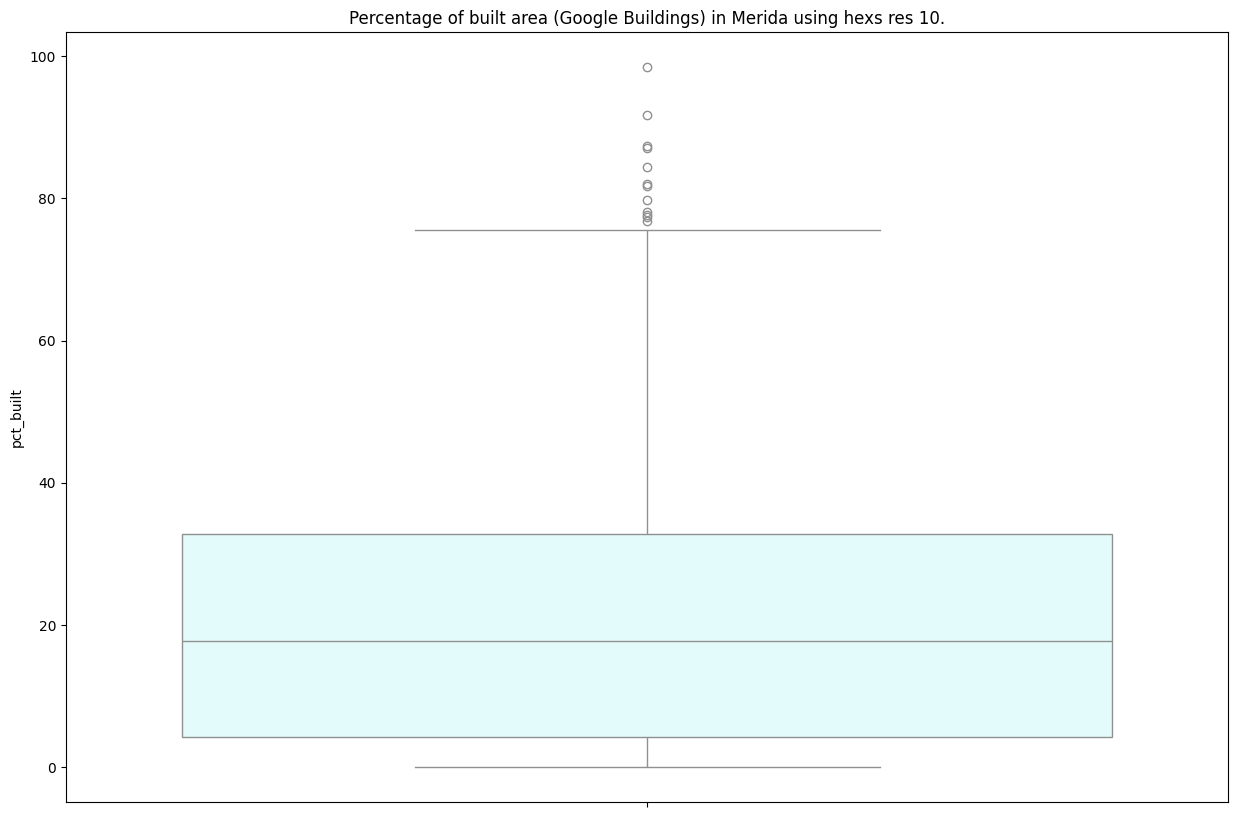

In [7]:
fig,ax=plt.subplots(figsize=(15,10))
sns.boxplot(builtarea_gdf.pct_built,
            color='lightcyan',
            zorder=0,
            ax=ax)
ax.set_title(f'Percentage of built area (Google Buildings) in {city} using hexs res {res}.')

In [8]:
if save_output:
    builtarea_gdf.to_file(map_output_dir + f"/{city}_builtarea_byhex_{res}.gpkg")